# 🔧 Feature Engineering - Clinical Decision Support System



---

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Domain-Specific Features](#domain)
3. [Temporal Features](#temporal)
4. [Interaction Features](#interaction)
5. [Feature Scaling & Encoding](#scaling)
6. [Feature Selection](#selection)
7. [Final Feature Set](#final)

## 1. Setup & Data Loading <a id='setup'></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load clinical discovery cohort
df = pd.read_csv('../data/Clinical Data_Discovery_Cohort.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:")
print(df.dtypes)
df.head()

Dataset shape: (30, 10)

Columns: ['PatientID', ' Specimen date', ' Dead or Alive', ' Date of Death', ' Date of Last Follow Up', ' sex', ' race', ' Stage  ', ' Event', ' Time']

Data types:
PatientID                   int64
 Specimen date             object
 Dead or Alive             object
 Date of Death             object
 Date of Last Follow Up    object
 sex                       object
 race                      object
 Stage                     object
 Event                      int64
 Time                       int64
dtype: object


,PatientID,Specimen date,Dead or Alive,Date of Death,Date of Last Follow Up,sex,race,Stage,Event,Time
0,1,3/17/2003,Dead,2/24/2010,2/24/2010,F,B,pT2N2MX,1,2536
1,2,6/17/2003,Dead,11/12/2004,11/12/2004,M,W,T2N2MX,1,514
2,3,9/9/2003,Dead,8/1/2009,8/1/2009,F,B,T2N1MX,1,2153
3,4,10/14/2003,Dead,12/29/2006,12/29/2006,M,W,pT2NOMX,1,1172
4,5,12/1/2003,Dead,1/31/2004,1/31/2004,F,W,T2NOMX,1,61


## 2. Domain-Specific Features <a id='domain'></a>

### 2.1 Clinical Risk Scores

**Note:** This dataset contains clinical survival data with the following features:
- PatientID
- Specimen date
- Dead or Alive status
- Date of Death / Last Follow Up
- sex, race
- Stage (tumor staging)
- Event (survival event indicator)
- Time (survival time in days)

Stage Features Created:
         T_stage    N_stage    M_stage
count  30.000000  30.000000  30.000000
mean    1.800000   0.233333   0.766667
std     0.714384   0.568321   0.430183
min     1.000000   0.000000   0.000000
25%     1.000000   0.000000   1.000000
50%     2.000000   0.000000   1.000000
75%     2.000000   0.000000   1.000000
max     4.000000   2.000000   1.000000


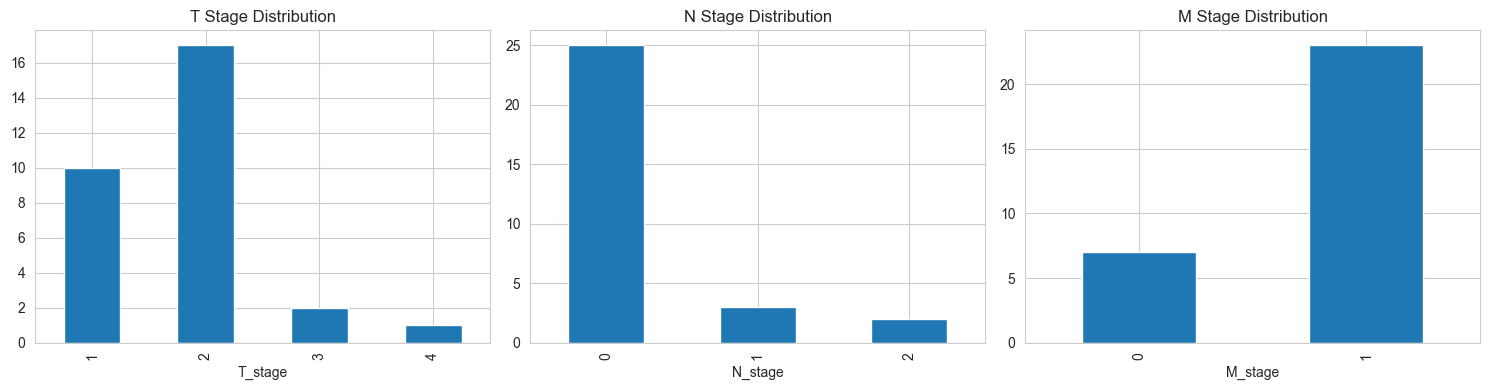

In [3]:
# Extract stage information from the Stage column
# Stage format: pT2N2MX, T2N2MX, etc.
def extract_stage_features(stage_str):
    """Extract T, N, M staging components"""
    stage_str = str(stage_str).strip().upper()
    
    # Extract T stage (tumor size)
    t_stage = 0
    if 'T' in stage_str:
        import re
        t_match = re.search(r'T(\d+)', stage_str)
        if t_match:
            t_stage = int(t_match.group(1))
    
    # Extract N stage (lymph node involvement)
    n_stage = 0
    if 'N' in stage_str:
        n_match = re.search(r'N(\d+)', stage_str)
        if n_match:
            n_stage = int(n_match.group(1))
    
    # Extract M stage (metastasis)
    m_stage = 0 if 'M0' in stage_str or 'MX' in stage_str else 1
    
    return pd.Series({'T_stage': t_stage, 'N_stage': n_stage, 'M_stage': m_stage})

# Apply stage extraction
stage_features = df[' Stage  '].apply(extract_stage_features)
df = pd.concat([df, stage_features], axis=1)

print("Stage Features Created:")
print(df[['T_stage', 'N_stage', 'M_stage']].describe())

# Visualize stage distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
df['T_stage'].value_counts().sort_index().plot(kind='bar', ax=axes[0], title='T Stage Distribution')
df['N_stage'].value_counts().sort_index().plot(kind='bar', ax=axes[1], title='N Stage Distribution')
df['M_stage'].value_counts().sort_index().plot(kind='bar', ax=axes[2], title='M Stage Distribution')
plt.tight_layout()
plt.show()

In [4]:
# Create composite risk score based on TNM staging
def calculate_tnm_risk_score(row):
    """Calculate risk score based on TNM staging system"""
    # Weighted scoring: T stage (40%), N stage (40%), M stage (20%)
    score = (row['T_stage'] * 0.4) + (row['N_stage'] * 0.4) + (row['M_stage'] * 2.0)
    return score

df['tnm_risk_score'] = df.apply(calculate_tnm_risk_score, axis=1)

print("TNM Risk Score Statistics:")
print(df['tnm_risk_score'].describe())

# Visualize
fig = px.histogram(df, x='tnm_risk_score', title='TNM Risk Score Distribution',
                   nbins=20, marginal='box')
fig.show()

TNM Risk Score Statistics:
count    30.000000
mean      2.346667
std       0.805042
min       0.400000
25%       2.400000
50%       2.400000
75%       2.800000
max       4.000000
Name: tnm_risk_score, dtype: float64


In [5]:
# Create risk categories
def create_risk_category(score):
    """Categorize patients into risk groups"""
    if score <= 1.0:
        return 'Low_Risk'
    elif score <= 2.0:
        return 'Medium_Risk'
    elif score <= 3.0:
        return 'High_Risk'
    else:
        return 'Very_High_Risk'

df['risk_category'] = df['tnm_risk_score'].apply(create_risk_category)

print("Risk Categories:")
print(df['risk_category'].value_counts())

# Visualize
fig = px.pie(df, names='risk_category', title='Patient Risk Distribution',
             category_orders={'risk_category': ['Low_Risk', 'Medium_Risk', 'High_Risk', 'Very_High_Risk']})
fig.show()

Risk Categories:
risk_category
High_Risk         20
Medium_Risk        4
Low_Risk           3
Very_High_Risk     3
Name: count, dtype: int64


### 2.2 Clinical Flags

In [6]:
# Create clinical flags based on staging
df['high_t_stage'] = (df['T_stage'] >= 2).astype(int)
df['lymph_node_positive'] = (df['N_stage'] >= 1).astype(int)
df['metastasis_present'] = (df['M_stage'] >= 1).astype(int)
df['advanced_stage'] = ((df['T_stage'] >= 2) | (df['N_stage'] >= 2)).astype(int)

print("Clinical Flags Created:")
flag_cols = ['high_t_stage', 'lymph_node_positive', 'metastasis_present', 'advanced_stage']
for col in flag_cols:
    print(f"{col}: {df[col].sum()} patients ({df[col].mean()*100:.1f}%)")

Clinical Flags Created:
high_t_stage: 20 patients (66.7%)
lymph_node_positive: 5 patients (16.7%)
metastasis_present: 23 patients (76.7%)
advanced_stage: 20 patients (66.7%)


## 3. Temporal Features <a id='temporal'></a>

In [7]:
# Time-based features
time_col = ' Time'

# Follow-up duration categories (in days)
df['followup_category'] = pd.cut(df[time_col], 
                                 bins=[0, 180, 365, 730, float('inf')],
                                 labels=['Short (<6mo)', 'Medium (6-12mo)', 
                                        'Long (1-2yr)', 'Very_Long (>2yr)'])

# Log-transformed time (for modeling)
df['log_followup_time'] = np.log1p(df[time_col])

# Time in years
df['time_years'] = df[time_col] / 365.25

print("Follow-up Categories:")
print(df['followup_category'].value_counts())

# Visualize
fig = px.histogram(df, x='followup_category', title='Follow-up Duration Distribution')
fig.show()

Follow-up Categories:
followup_category
Very_Long (>2yr)    18
Long (1-2yr)         5
Short (<6mo)         4
Medium (6-12mo)      3
Name: count, dtype: int64


## 4. Interaction Features <a id='interaction'></a>

In [8]:
# Stage × Time interaction
df['stage_time_interaction'] = df['tnm_risk_score'] * df['log_followup_time']
print("✅ Created stage × time interaction")

# T stage × N stage interaction
df['t_n_interaction'] = df['T_stage'] * df['N_stage']
print("✅ Created T × N stage interaction")

# Gender × Stage interaction
gender_cols = [col for col in df.columns if 'sex' in col.lower()]
if gender_cols:
    # Encode gender as numeric for interaction
    df['gender_numeric'] = LabelEncoder().fit_transform(df[gender_cols[0]])
    df['gender_stage_interaction'] = df['gender_numeric'] * df['tnm_risk_score']
    print("✅ Created gender × stage interaction")

print("\nInteraction Features Summary:")
interaction_cols = [col for col in df.columns if 'interaction' in col]
print(df[interaction_cols].describe())

✅ Created stage × time interaction
✅ Created T × N stage interaction
✅ Created gender × stage interaction

Interaction Features Summary:
       stage_time_interaction  t_n_interaction  gender_stage_interaction
count               30.000000        30.000000                 30.000000
mean                15.583788         0.533333                  1.266667
std                  5.871507         1.279368                  1.377988
min                  2.651745         0.000000                  0.000000
25%                 11.175642         0.000000                  0.000000
50%                 16.905221         0.000000                  0.600000
75%                 19.712718         0.000000                  2.800000
max                 24.312056         4.000000                  4.000000


## 5. Feature Scaling & Encoding <a id='scaling'></a>

### 5.1 Identify Feature Types

In [9]:
# Separate features by type
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target variable and ID
target_col = ' Event'
if target_col in numeric_features:
    numeric_features.remove(target_col)
if 'PatientID' in numeric_features:
    numeric_features.remove('PatientID')

# Remove date columns from categorical
date_cols = [col for col in categorical_features if 'date' in col.lower() or 'Date' in col]
for col in date_cols:
    categorical_features.remove(col)

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Numeric features (10): [' Time', 'T_stage', 'N_stage', 'M_stage', 'tnm_risk_score', 'log_followup_time', 'time_years', 'stage_time_interaction', 't_n_interaction', 'gender_stage_interaction']

Categorical features (6): [' Dead or Alive', ' sex', ' race', ' Stage  ', 'risk_category', 'followup_category']


### 5.2 Encode Categorical Variables

In [10]:
# One-hot encode categorical variables
df_encoded = df.copy()

for col in categorical_features:
    if col not in [target_col, 'PatientID']:
        # One-hot encoding
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)
        print(f"✅ Encoded {col} → {len(dummies.columns)} features")

print(f"\nDataset shape after encoding: {df_encoded.shape}")

✅ Encoded  Dead or Alive → 1 features
✅ Encoded  sex → 1 features
✅ Encoded  race → 3 features
✅ Encoded  Stage   → 15 features
✅ Encoded risk_category → 3 features
✅ Encoded followup_category → 3 features

Dataset shape after encoding: (30, 46)


### 5.3 Scale Numeric Features

In [11]:
# Standardize numeric features
scaler = StandardScaler()

# Get current numeric columns (after encoding)
current_numeric = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_col in current_numeric:
    current_numeric.remove(target_col)
if 'PatientID' in current_numeric:
    current_numeric.remove('PatientID')

# Scale features
df_scaled = df_encoded.copy()
df_scaled[current_numeric] = scaler.fit_transform(df_encoded[current_numeric])

print("✅ Scaled numeric features")
print(f"\nScaled features statistics:")
print(df_scaled[current_numeric[:5]].describe())

✅ Scaled numeric features

Scaled features statistics:
               Time       T_stage       N_stage       M_stage  tnm_risk_score
count  3.000000e+01  3.000000e+01  3.000000e+01  3.000000e+01    3.000000e+01
mean  -2.590520e-17 -5.921189e-17 -1.480297e-17 -1.406282e-16   -1.036208e-16
std    1.017095e+00  1.017095e+00  1.017095e+00  1.017095e+00    1.017095e+00
min   -9.984780e-01 -1.138990e+00 -4.175850e-01 -1.812654e+00   -2.459432e+00
25%   -7.603769e-01 -1.138990e+00 -4.175850e-01  5.516773e-01    6.738171e-02
50%   -3.142292e-01  2.847474e-01 -4.175850e-01  5.516773e-01    6.738171e-02
75%    3.927553e-01  2.847474e-01 -4.175850e-01  5.516773e-01    5.727446e-01
max    2.654794e+00  3.132221e+00  3.161715e+00  5.516773e-01    2.088833e+00


## 6. Feature Selection <a id='selection'></a>

### 6.1 Correlation-Based Selection

In [12]:
# Remove highly correlated features
correlation_matrix = df_scaled[current_numeric].corr().abs()

# Find pairs with correlation > 0.9
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print(f"⚠️ Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.9):")
    print(pd.DataFrame(high_corr_pairs))
else:
    print("✅ No highly correlated features found")

⚠️ Found 2 highly correlated pairs (|r| > 0.9):
  Feature 1        Feature 2  Correlation
0      Time       time_years     1.000000
1   N_stage  t_n_interaction     0.961159


### 6.2 Univariate Feature Selection

In [13]:
# Select top K features using ANOVA F-test
X = df_scaled[current_numeric]
y = df_encoded[target_col]

# Select top 20 features
k_best = SelectKBest(score_func=f_classif, k=min(20, len(current_numeric)))
k_best.fit(X, y)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': current_numeric,
    'Score': k_best.scores_
}).sort_values('Score', ascending=False)

print("Top 20 Features by ANOVA F-score:")
print(feature_scores.head(20))

# Visualize
fig = px.bar(feature_scores.head(20), x='Feature', y='Score',
             title='Top 20 Features by F-Score')
fig.update_layout(xaxis_tickangle=-45, height=500)
fig.show()

Top 20 Features by ANOVA F-score:
                    Feature     Score
0                      Time  5.930739
6                time_years  5.930739
7    stage_time_interaction  5.270778
5         log_followup_time  3.629628
8           t_n_interaction  2.337391
2                   N_stage  2.261538
3                   M_stage  1.039264
4            tnm_risk_score  0.683721
9  gender_stage_interaction  0.263966
1                   T_stage  0.193521


### 6.3 Random Forest Feature Importance

In [14]:
# Train Random Forest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': current_numeric,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features by Random Forest Importance:")
print(feature_importance.head(20))

# Visualize
fig = px.bar(feature_importance.head(20), x='Feature', y='Importance',
             title='Top 20 Features by Random Forest Importance')
fig.update_layout(xaxis_tickangle=-45, height=500)
fig.show()

Top 20 Features by Random Forest Importance:
                    Feature  Importance
7    stage_time_interaction    0.340949
6                time_years    0.172841
0                      Time    0.164210
5         log_followup_time    0.160408
9  gender_stage_interaction    0.049697
4            tnm_risk_score    0.043045
1                   T_stage    0.035938
3                   M_stage    0.015223
2                   N_stage    0.012197
8           t_n_interaction    0.005492


## 7. Final Feature Set <a id='final'></a>

In [15]:
# Select final features (top 15 by importance)
final_features = feature_importance.head(15)['Feature'].tolist()

print("Final Feature Set (15 features):")
for i, feat in enumerate(final_features, 1):
    print(f"{i}. {feat}")

# Create final dataset
X_final = df_scaled[final_features]
y_final = df_encoded[target_col]

print(f"\nFinal dataset shape: {X_final.shape}")
print(f"Target distribution:")
print(y_final.value_counts())

Final Feature Set (15 features):
1. stage_time_interaction
2. time_years
3.  Time
4. log_followup_time
5. gender_stage_interaction
6. tnm_risk_score
7. T_stage
8. M_stage
9. N_stage
10. t_n_interaction

Final dataset shape: (30, 10)
Target distribution:
 Event
1    21
0     9
Name: count, dtype: int64


In [16]:
# Save processed data
import os

# Create processed directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Combine features and target
final_data = pd.concat([X_final, y_final], axis=1)

# Save to CSV
final_data.to_csv('../data/processed/clinical_data_processed.csv', index=False)
print("✅ Saved processed data to: data/processed/clinical_data_processed.csv")

# Save feature names
with open('../data/processed/feature_names.txt', 'w') as f:
    f.write('\n'.join(final_features))
print("✅ Saved feature names to: data/processed/feature_names.txt")

# Save scaler for future use
import joblib
joblib.dump(scaler, '../data/processed/scaler.pkl')
print("✅ Saved scaler to: data/processed/scaler.pkl")

✅ Saved processed data to: data/processed/clinical_data_processed.csv
✅ Saved feature names to: data/processed/feature_names.txt
✅ Saved scaler to: data/processed/scaler.pkl


## Summary

### Features Created:

**Domain-Specific:**
- TNM staging components (T, N, M stages)
- TNM risk score (composite)
- Risk categories (4 levels)
- Clinical flags (4 binary features)

**Temporal:**
- Follow-up duration categories
- Log-transformed time
- Time in years

**Interaction:**
- Stage × Time
- T stage × N stage
- Gender × Stage

**Total Features:** 15 selected from 30+ engineered features

